# Clustering Prototype - Initial Version
## Sentence embedding, dimensionality reduction, feature selection, clustering, and explaining clusters.


This file will allow you to set variables to run clustering and explainability on a dataset. In the next cell, you will be able to:

1.   Specify a dataset
     - [IMDB Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) for sentiment analysis
     - [Customer Support Ticket Dataset](https://www.kaggle.com/datasets/suraj520/customer-support-ticket-dataset)
2.   Specify an embedding method
     - Sentence-BERT ([paper](https://arxiv.org/abs/1908.10084), [documentation](https://www.sbert.net/))
     - LLM2Vec ([paper](https://arxiv.org/abs/2404.05961), [GitHub](https://github.com/McGill-NLP/llm2vec))
2.   Flag if you would like dimensionality reduction (PCA) to occur
3.   Flag if you would like feature selection (decision trees) to occur

Based on these options, the file will run K-means clustering and labeling on the dataset.

Finally, it will prompt an LLM to explain the cluster groupings.


## Set options for clustering

For each of the sections in the following cell, uncomment the option you wish to use for each section and ensure the rest are commented out.

In [1]:
# Dataset --------------------------------------------
dataset = "IMDB.csv"
text_col = "review"
label_col = "sentiment"
# dataset = "helpdesk_customer_tickets.csv"
# text_col =
# label_col =

# Embedding method -----------------------------------
method = "s_bert"
# method = "llm2vec"

# Dimensionality reduction (PCA) ---------------------
pca = True
# pca = False

# Feature selection (decision trees)  ----------------
decision_trees = True
# decision_trees = False

# Cluster count selection ----------------------------
cluster_count_method = "WCSS Elbow" 
# cluster_count_method = "Silhouette Score"
# cluster_count = 10

## Imports and Requirements

This notebook was ran on a newly created venv through conda in order to gather the necessary requiremets. The venv was running Python 3.11.10. 

The following packages were present:


| Name                     | Version        | Build                | Channel      |
|--------------------------|----------------|----------------------|--------------|
| appnope                  | 0.1.4          | pyhd8ed1ab_0         | conda-forge  |
| asttokens                | 2.4.1          | pyhd8ed1ab_0         | conda-forge  |
| bzip2                    | 1.0.8          | h6c40b1e_6           |              |
| ca-certificates          | 2024.9.24      | hecd8cb5_0           |              |
| certifi                  | 2024.8.30      | pypi_0               | pypi         |
| charset-normalizer       | 3.4.0          | pypi_0               | pypi         |
| comm                     | 0.2.2          | pyhd8ed1ab_0         | conda-forge  |
| contourpy                | 1.3.1          | pypi_0               | pypi         |
| cycler                   | 0.12.1         | pypi_0               | pypi         |
| debugpy                  | 1.8.8          | py311hc356e98_0      | conda-forge  |
| decorator                | 5.1.1          | pyhd8ed1ab_0         | conda-forge  |
| exceptiongroup           | 1.2.2          | pyhd8ed1ab_0         | conda-forge  |
| executing                | 2.1.0          | pyhd8ed1ab_0         | conda-forge  |
| filelock                 | 3.16.1         | pypi_0               | pypi         |
| fonttools                | 4.55.0         | pypi_0               | pypi         |
| fsspec                   | 2024.10.0      | pypi_0               | pypi         |
| huggingface-hub          | 0.26.2         | pypi_0               | pypi         |
| idna                     | 3.10           | pypi_0               | pypi         |
| importlib-metadata       | 8.5.0          | pyha770c72f_0        | conda-forge  |
| ipykernel                | 6.29.5         | pyh57ce528_0         | conda-forge  |
| ipython                  | 8.29.0         | pyh707e725_0         | conda-forge  |
| jedi                     | 0.19.2         | pyhff2d567_0         | conda-forge  |
| jinja2                   | 3.1.4          | pypi_0               | pypi         |
| joblib                   | 1.4.2          | pypi_0               | pypi         |
| jupyter_client           | 8.6.3          | pyhd8ed1ab_0         | conda-forge  |
| jupyter_core             | 5.7.2          | pyh31011fe_1         | conda-forge  |
| kiwisolver               | 1.4.7          | pypi_0               | pypi         |
| krb5                     | 1.21.3         | h37d8d59_0           | conda-forge  |
| libcxx                   | 19.1.3         | hf95d169_0           | conda-forge  |
| libedit                  | 3.1.20191231   | h0678c8f_2           | conda-forge  |
| libffi                   | 3.4.4          | hecd8cb5_1           |              |
| libsodium                | 1.0.20         | hfdf4475_0           | conda-forge  |
| markupsafe               | 3.0.2          | pypi_0               | pypi         |
| matplotlib               | 3.9.2          | pypi_0               | pypi         |
| matplotlib-inline        | 0.1.7          | pyhd8ed1ab_0         | conda-forge  |
| mpmath                   | 1.3.0          | pypi_0               | pypi         |
| ncurses                  | 6.4            | hcec6c5f_0           |              |
| nest-asyncio             | 1.6.0          | pyhd8ed1ab_0         | conda-forge  |
| networkx                 | 3.4.2          | pypi_0               | pypi         |
| numpy                    | 1.26.0         | pypi_0               | pypi         |
| openssl                  | 3.4.0          | hd471939_0           | conda-forge  |
| packaging                | 24.2           | pyhd8ed1ab_0         | conda-forge  |
| pandas                   | 2.2.3          | pypi_0               | pypi         |
| parso                    | 0.8.4          | pyhd8ed1ab_0         | conda-forge  |
| pexpect                  | 4.9.0          | pyhd8ed1ab_0         | conda-forge  |
| pickleshare              | 0.7.5          | py_1003              | conda-forge  |
| pillow                   | 11.0.0         | pypi_0               | pypi         |
| pip                      | 24.2           | py311hecd8cb5_0      |              |
| platformdirs             | 4.3.6          | pyhd8ed1ab_0         | conda-forge  |
| prompt-toolkit           | 3.0.48         | pyha770c72_0         | conda-forge  |
| psutil                   | 6.1.0          | py311h1314207_0      | conda-forge  |
| ptyprocess               | 0.7.0          | pyhd3deb0d_0         | conda-forge  |
| pure_eval                | 0.2.3          | pyhd8ed1ab_0         | conda-forge  |
| pygments                 | 2.18.0         | pyhd8ed1ab_0         | conda-forge  |
| pyparsing                | 3.2.0          | pypi_0               | pypi         |
| python                   | 3.11.10        | h4d6d9e5_0           |              |
| python-dateutil          | 2.9.0          | pyhd8ed1ab_0         | conda-forge  |
| python_abi               | 3.11           | 2_cp311              | conda-forge  |
| pytz                     | 2024.2         | pypi_0               | pypi         |
| pyyaml                   | 6.0.2          | pypi_0               | pypi         |
| pyzmq                    | 26.2.0         | py311h4d3da15_3      | conda-forge  |
| readline                 | 8.2            | hca72f7f_0           |              |
| regex                    | 2024.11.6      | pypi_0               | pypi         |
| requests                 | 2.32.3         | pypi_0               | pypi         |
| safetensors              | 0.4.5          | pypi_0               | pypi         |
| scikit-learn             | 1.5.2          | pypi_0               | pypi         |
| scipy                    | 1.14.1         | pypi_0               | pypi         |
| sentence-transformers    | 3.3.0          | pypi_0               | pypi         |
| setuptools               | 75.1.0         | py311hecd8cb5_0      |              |
| six                      | 1.16.0         | pyh6c4a22f_0         | conda-forge  |
| sqlite                   | 3.45.3         | h6c40b1e_0           |              |
| stack_data               | 0.6.2          | pyhd8ed1ab_0         | conda-forge  |
| sympy                    | 1.13.3         | pypi_0               | pypi         |
| threadpoolctl            | 3.5.0          | pypi_0               | pypi         |
| tk                       | 8.6.14         | h4d00af              |              |
| tokenizers               | 0.20.3         | pypi_0               | pypi         |
| torch                    | 2.2.2          | pypi_0               | pypi         |
| tornado                  | 6.4.1          | py311h3336109_1      | conda-forge  |
| tqdm                     | 4.67.0         | pypi_0               | pypi         |
| traitlets                | 5.14.3         | pyhd8ed1ab_0         | conda-forge  |
| transformers             | 4.46.2         | pypi_0               | pypi         |
| typing_extensions        | 4.12.2         | pyha770c72_0         | conda-forge  |
| tzdata                   | 2024.2         | pypi_0               | pypi         |
| urllib3                  | 2.2.3          | pypi_0               | pypi         |
| wcwidth                  | 0.2.13         | pyhd8ed1ab_0         | conda-forge  |
| wheel                    | 0.44.0         | py311hecd8cb5_0      |              |
| xz                       | 5.4.6          | h6c40b1e_1           |              |
| zeromq                   | 4.3.5          | h7130eaa_7           | conda-forge  |
| zipp                     | 3.21.0         | pyhd8ed1ab_0         | conda-forge  |
| zlib                     | 1.2.13         | h4b97444_1           |              |



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

/Users/nickmondello/miniconda3/envs/ServiceNow/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Read dataset --------------------------------------------------------------
df = pd.read_csv(dataset)
df = df.sample(frac=0.05)
text = df[text_col]

# Calculate embeddings ------------------------------------------------------
# Note: this is a time-consuming step (~7 min)
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(text.tolist(), convert_to_tensor=False)

In [4]:
# Dimensionality Reduction (PCA) --------------------------------------------
if pca:
  pca_model = PCA(n_components=2)
  embeddings_2d = pca_model.fit_transform(embeddings)

## Incorporate feature selection using decision trees

"Shrink" or drop the non-important features with respect to the output class, and "expand" the features that are more important to determining the output class.

In [5]:
# Feature Selection (Decision Trees) ----------------------------------------
if decision_trees:
  X_train, X_test, y_train, y_test = train_test_split(embeddings, df[label_col], random_state = 8, test_size = 0.3)

  # Fit the decision tree model
  decision_tree_model = DecisionTreeClassifier()
  decision_tree_model.fit(X_train, y_train)

  # Access feature importances
  feature_importances = decision_tree_model.feature_importances_

  # Delete low-importance features
  low_importance_indices = np.where(feature_importances < 0.025)[0] # random sampling prob. -- 1/384 = 0.0026
  embeddings_small = np.delete(embeddings, low_importance_indices, axis=1)
  X_train_reduced = np.delete(X_train, low_importance_indices, axis=1)
  X_test_reduced = np.delete(X_test, low_importance_indices, axis=1)
  print(f"Embeddings went from size {len(X_train[0])} to {len(X_train_reduced[0])}")

Embeddings went from size 384 to 4


## K-means clustering

First determine optimal number of clusters through either WCSS elbow point selection or silhouette score maximization.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/nickmondello/miniconda3/envs/ServiceNow/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


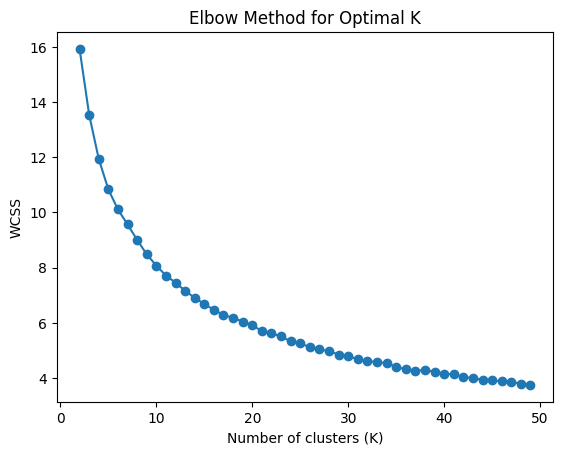

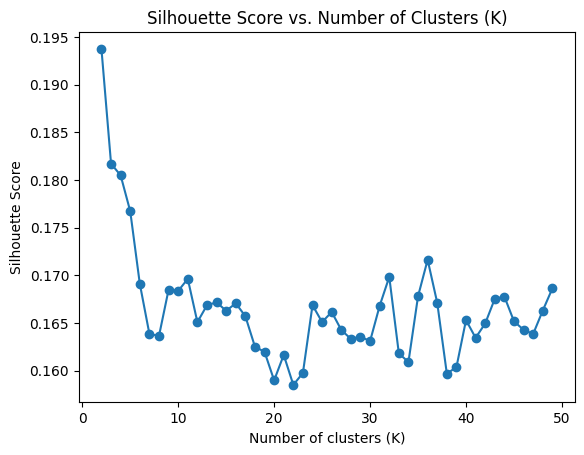

In [6]:

wcss_list = []  # within-cluster sum of squares
silhouette_scores_list = []

# Calculate WCSS for each K
upper_bound_k = 50
for k in range(2, upper_bound_k):  # Choosing range from 1 to 50 for demonstration
    # wcss
    kmeans_experiment = KMeans(n_clusters=k, random_state=0)
    kmeans_experiment.fit(embeddings_small)
    wcss_list.append(kmeans_experiment.inertia_)

    labels = kmeans_experiment.fit_predict(embeddings_small)
    score = silhouette_score(embeddings_small, labels)
    silhouette_scores_list.append(score)

# Plot the WCSS values
plt.plot(range(2, upper_bound_k), wcss_list, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.show()

# Plot silhouette scores to find optimal K
plt.plot(range(2, upper_bound_k), silhouette_scores_list, marker='o')
plt.title('Silhouette Score vs. Number of Clusters (K)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

Determine optimal k. Either maximize Silhouette Score or estimate elbow point of WCSS chart.

In [7]:
if cluster_count_method == "Silhouette Score":
    max_index = np.argmax(silhouette_scores_list)
    num_clusters = max_index + 2 # index 0 corresponds to 2 clusters
elif cluster_count_method == "WCSS Elbow":
    # elbow point occurs when the difference of slopes of a point to its two neighbors is maximized
    neighbor_range = 3 # how many counts out to determine slopes
    neighbor_slope_difference = [abs(abs(wcss_list[i]-wcss_list[i+neighbor_range]) - abs(wcss_list[i-neighbor_range]-wcss_list[i])) 
                                 for i in range(neighbor_range,len(wcss_list)-neighbor_range)]
    max_index = np.argmax(silhouette_scores_list)
    num_clusters = max_index + neighbor_range + 1# index 0 corresponds to neighbor_range + 1 clusters



else: 
    if isinstance(cluster_count_method, int):
        num_clusters = cluster_count_method
    else:
        print("ERROR: must choose valid cluster_count_method")


# Perform K-means clustering
# num_clusters = 5  # Define the number of clusters you want
print(f"Chosen number of clusters: {num_clusters}\ncluster_count_method: {cluster_count_method}")
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(embeddings_small)

# Print WCCS (within-cluster sum of squares) metric
wcss = kmeans.inertia_
print("Within-Cluster Sum of Squares:", wcss)

# NOTE: not sure what to do about this piece below (plotting to determine ideal num clusters)

Chosen number of clusters: 4
cluster_count_method: WCSS Elbow
Within-Cluster Sum of Squares: 12.179757118225098


## Find closest examples to cluster centroids

Currently, we are using cosine similarity to find the data point closest to the cluster centroids as a proxy for explaining or representing that cluster. We can also explore other ways (e.g. using LLMs) to explain clusters.

In [8]:
# For each cluster centroid, print the closest data point
corpus = list(df[text_col])
centroid_embeddings = kmeans.cluster_centers_
for i, centroid_vec in enumerate(centroid_embeddings):
    similarity_scores = util.cos_sim(centroid_vec, embeddings_small)
    closest_data_point = corpus[int(similarity_scores.argmax())]
    print(f"Centroid of cluster {i}:\n-----\n{closest_data_point}\n-----\n\n")

Centroid of cluster 0:
-----
This was the first regular filmed Columbo movie episode but yet it aired as the second, after Steven Spielberg's "Columbo: Murder by the Book". It's also at the same time among one of the better ones!<br /><br />Bernard L. Kowalski was one great creative director! No wonder that they later asked him to direct three more Columbo movies. The movie has some real creative and innovative shot sequences and the movie as a whole is also clearly made with style, passion and eye for detail. Every shot connects and is a reason why this movie is better and also better looking just any other average made for TV movie. It's definitely one of the better directed Columbo movies.<br /><br />It's a quit original Columbo entry for a couple of reasons. The murder is more or less an accident and was an impulsive act. So the killer this time doesn't have any time to plan out the 'perfect murder' in advance and his to clean up any of the traces afterward and has to dispose the b

In [9]:
# Print a few data points from each cluster to also help with explainability
for i in range(num_clusters):
    print(f"\n\n\nCluster {i}:")
    samples = df[df['cluster'] == i][text_col].tolist()[:5]
    for s in samples:
        print("--")
        print(s)
    print("--")




Cluster 0:
--
Times are tough for Angel Town, gangs rule with an iron fist and for reasons mostly unknown (Mainly due to embarrassing writing) the gangs want a street kid, Martine to join the gangs, so they beat him up everyday. However due to the presence of an Olympic kick-boxer (Olivier "World's lamest actor" Gruner) named Jacques, hope is on the way. Angel Town is seriously one of the most inept message movies ever made (And I've seen my share) it seems to consist of the idea that all gang infested neighborhoods need, are French kick-boxers who can't act. Worst of all there are so many awkward moments it's just truly hilarious. Best of all comes from the exchange between Gruner and Aragon which basically sums up how ridiculous this thing is. To Wit: "You like the fighting? (Olivier grabs his Asian best friend in a headlock) I could kill him right? When I want him dead he dies! The reason why I don't want him dead is because i'm afraid of him, and I know that if I kill him his so